## Project Title
Project description

The notebook is structured as follows:
1. 

## Import Libraries

In [609]:
# For data manipulation
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# For Visualisation
import matplotlib.pyplot as plt

# For ignoring warnings
import warnings
warnings.simplefilter("ignore")

# For data visualisation
import matplotlib.pyplot as plt

# Helper functions
import sys
sys.path.append("..")

<a id='import'></a>
## Import the Data

In [610]:
# Read the data
options_data = pd.read_csv('./data/options_daily_sp500_2018_2022.csv', index_col=0)

# Change the index type to datetime
options_data.index = pd.to_datetime(options_data.index)

# Import the S&P 500 index daily data
daily_data_SP500 = pd.read_csv('./data/daily_sp500_2018_2022.csv', index_col=0)

# Change the index type to datetime
daily_data_SP500.index = pd.to_datetime(daily_data_SP500.index)

# Merge both dataframes to include the information of underlying data into options data
options_data = options_data.merge(daily_data_SP500[[
    'Open', 'High', 'Low', 'Close']], left_index=True, right_index=True, how='left').dropna()

option_chain = pd.read_csv('./data/option_chain_spx.csv', index_col=0)
option_chain.index = pd.to_datetime(option_chain.index)

## Helper Functions

In [612]:
# Find the likelihood for given parameters
def garch_likelihood(params, returns, vol):
    gamma = params[0]
    alpha = params[1]
    beta = params[2]
    log_likelihood = 0
    for i in range(1, len(returns)):
        variance = gamma * vol[0] + alpha * returns[i-1]**2 + beta * vol[i-1]
        log_likelihood -= np.log(variance) + returns[i]**2 / variance
    return -log_likelihood


initial_params = [0.1, 0.1, 0.1]
params_bounds = [(0,1), (0,1), (0,1)]

# Find max likelihood parameters
def estimate_params(args):
    # Define the GARCH(1,1) model's initial parameters and their bounds
    result = minimize(garch_likelihood, initial_params, args = args, bounds = params_bounds, method = 'SLSQP')
    return result.x

def forecast_volatility(params, returns, vol):
    gamma = params[0]
    alpha = params[1]
    beta = params[2]
    result = gamma * vol[0] + alpha * returns[-1]**2 + beta * vol[-1]
    return result

### Backtesting Functions

In [613]:
# Function to calculate the premium of a straddle
def premium(type, data):
    if type == 'CE':
        return data['C_LAST']
    return data['P_LAST']

# Function to setup a straddle
def new_straddle(data):
    straddle = pd.DataFrame()
    straddle['option_type'] = ['CE', 'PE']
    straddle['strike'] = data.STRIKE
    straddle['premium'] = straddle.apply(lambda x: premium(x['option_type'], data), axis=1)
    return straddle

def trade(direction, entry_price, entry_time, exit_price, exit_time):
    pnl = (exit_price - entry_price) * direction
    position = 'Long' if direction == 1 else 'Short'
    trades = pd.DataFrame(columns = ['Position', 'Entry Time', 'Entry Price', 'Exit Time', 'Exit Price', 'PnL'])
    return trades.append({
        'Position': position,
        'Entry Time' : entry_time,
        'Entry Price' : entry_price,
        'Exit Time' : exit_time, 
        'Exit Price': exit_price, 
        'PnL' : pnl
    }, ignore_index=True)



<a id='signals'></a>
## Generate Signals
In this section a signal is generated at the start of every month, where the forecasted volatility is compared to the implied volatility of options expiring at the end of them. If the forecasted volatility is greater than the implied volatility, a straddle is bought, while if the forecasted volatility is less than the implied volatility, a straddle is bought. 

In [614]:
# Run the strategy for the last year of data and generate a signal every 5 days
last_year = options_data[252*4:]
last_signal_target = 5
last_signal = last_signal_target
# Create a column to store signals
options_data['signal'] = 0
options_data['forecasted_volatility'] = np.nan
# Dictionary used to specify which aggregate function to apply to columns when changing from daily data to monthly data
columns_functions ={
    'Open': 'first',
    'Close': 'last',
    'High': 'max',
    'Low': 'min'
}

for date in last_year.index:
    if last_signal >= last_signal_target:
        # We will be using data from the last 4 years to forecast volatility
        data = options_data[:date][-252*4:]
        data.index = pd.to_datetime(data.index)
        # Convert into monthly data to calculate monthly volatility
        monthly_data = data.resample('M').agg(columns_functions).dropna()
        # Estimate the volatility using the three different estimators
        
        # Close to Close volatility
        monthly_returns = np.log(monthly_data['Close']/monthly_data['Close'].shift(1)).dropna()
        monthly_data['c_to_c'] = monthly_returns.std()
        
        # Parkinson
        high_low = np.log(monthly_data['High']/monthly_data['Low'])
        monthly_data['parkinson'] = np.sqrt((1/(4*np.log(2)))*(high_low**2).sum())
        
        # Garman-Klass
        monthly_data['garman_klass'] = np.sqrt((0.5)*((high_low**2).sum()) - (((2 * np.log(2))-1)*(monthly_returns**2).sum()))

        # Average Volatility        
        avg_vol = (monthly_data['garman_klass'] + monthly_data['parkinson'] + monthly_data['c_to_c']) / 3

        # Estimate GARCH(1,1) model parametrs using max likelihood estimation and forecast volatility
        parameters = estimate_params((monthly_returns, avg_vol))
        forecasted_volatility = forecast_volatility(parameters, monthly_returns, avg_vol)
        options_data.at[date, 'forecasted_volatility'] = forecasted_volatility * 100

        # Compare with implied volatility
        if forecasted_volatility*100 > options_data.loc[date].C_IV and forecasted_volatility*100 > options_data.loc[date].P_IV:
            # Set signal for the following 5 trading sessions or days????
            options_data.loc[date:date+pd.DateOffset(days = 4), 'signal'] = 1
            last_signal = 0
        elif forecasted_volatility*100 < options_data.loc[date].C_IV and forecasted_volatility*100 < options_data.loc[date].P_IV:
            # Set signal for the following 5 trading sessions or days????
            options_data.loc[date:date+pd.DateOffset(days = 4), 'signal'] = -1
            last_signal = 0
    else:
        last_signal += 1

## Backtest


In [615]:
current_position = 0
backtest_data = options_data["signal"].copy()[242*4:]
backtest_data.pnl = 0
prev_signal = np.nan
trade_book = pd.DataFrame(columns = ['Position', 'Entry Time', 'Entry Price', 'Exit Time', 'Exit Price', 'PnL'])

for date, signal in backtest_data.items():
    # Enter trade
    if current_position == 0 and signal !=0:
        straddle = new_straddle(options_data.loc[date])
        strike = options_data.loc[date].STRIKE
        entry_time = date
        entry_price = round((straddle['premium']).sum(), 2)
        current_position = signal
    # Exit trade
    elif current_position != 0 and signal == 0:
        exit_time = date
        exit = option_chain.loc[date.strftime('%Y-%m-%d')]
        exit = exit[exit.Strike == strike]
        exit_price = exit['C_last'].at[exit.index[0]] + exit['P_last'].at[exit.index[0]]
        trade_book = pd.concat([trade_book, trade(current_position, entry_price, entry_time, exit_price, exit_time)])
        trade_book = trade_book.reset_index(drop = True)
        current_position = 0

trade_book

,Position,Entry Time,Entry Price,Exit Time,Exit Price,PnL
0,Long,2022-04-14,148.82,2022-04-19,124.58,-24.24
1,Long,2022-04-25,105.20,2022-05-02,269.10,163.90
2,Short,2022-05-04,275.32,2022-05-09,297.70,-22.38
3,Long,2022-05-13,149.50,2022-05-18,163.94,14.44
4,Long,2022-05-23,116.79,2022-06-01,195.16,78.37
5,Short,2022-06-02,224.83,2022-06-07,219.46,5.37
6,Long,2022-06-10,194.25,2022-06-15,236.97,42.72
7,Long,2022-06-22,137.75,2022-06-27,75.52,-62.23
8,Long,2022-07-05,206.18,2022-07-11,177.40,-28.78
9,Short,2022-07-13,173.36,2022-07-18,139.04,34.32


<a id='analytics'></a>
## Strategy Analytics

In [616]:
trade_book['cumulative_pnl'] = trade_book['PnL'].cumsum()

analytics = pd.DataFrame(index=['Strategy'])
# Calculate total PnL
analytics['Total PnL'] = trade_book.PnL.sum()

# Number of total trades
analytics['Total Trades'] = len(trade_book)


# Profitable trades
analytics['Positive Trades'] = len(trade_book.loc[trade_book.PnL > 0])

# Loss-making trades
analytics['Negative Trades'] = len(trade_book.loc[trade_book.PnL <= 0])

# Per trade profit/loss of winning trades
analytics['Per Trade PnL of Winners'] = round(trade_book.loc[trade_book.PnL > 0].PnL.mean(), 2)

# Per trade profit/loss of losing trades
analytics['Per Trade PnL of Losers'] = round(abs(trade_book.loc[trade_book.PnL <= 0].PnL.mean()), 2)

# Profit factor
winners = trade_book.loc[trade_book.PnL > 0]
made = winners.PnL.sum()
losers = trade_book.loc[trade_book.PnL<= 0]
lost = losers.PnL.sum()
analytics['Profit Factor'] = round(abs(made/lost), 2)

analytics.head()

,Total PnL,Total Trades,Positive Trades,Negative Trades,Per Trade PnL of Winners,Per Trade PnL of Losers,Profit Factor
Strategy,438.62,18,12,6,52.07,31.03,3.36


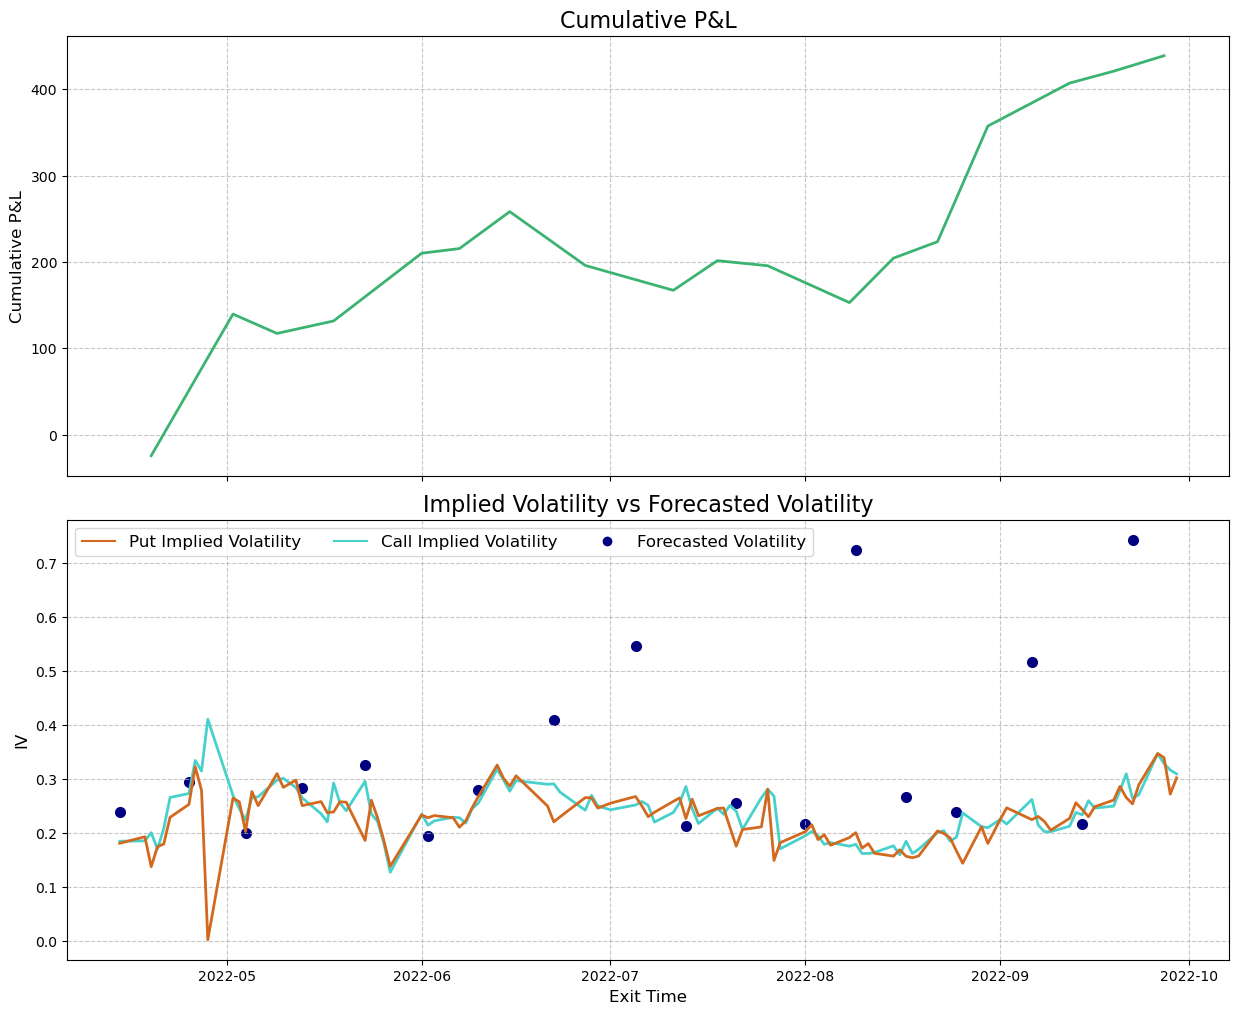

In [629]:
# Create a figure and axes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

# Plot the main data on the top axis (ax1)
ax1.plot(trade_book['Exit Time'], trade_book['cumulative_pnl'], color='mediumseagreen', linestyle='-', linewidth=2)
ax1.set_ylabel('Cumulative P&L', fontsize=12)
ax1.set_title('Cumulative P&L', fontsize=16)

# Add grid lines to the top plot
ax1.grid(True, linestyle='--', alpha=0.7)

# Plot additional data on the bottom axis (ax2)
ax2.plot(options_data[252*4:].index, options_data[252*4:].C_IV, color='mediumturquoise', linestyle='-', linewidth=2, label='Call Implied Volatility')
ax2.plot(options_data[252*4:].index, options_data[252*4:].P_IV, color='chocolate', linestyle='-', linewidth=2, label='Put Implied Volatility')
ax2.scatter(options_data[252*4:].index, options_data[252*4:]['forecasted_volatility'], color='navy', linestyle='-', linewidth=2, label='Forecasted Volatility')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Volatility(%)', fontsize=12)
ax2.set_title('Implied Volatility vs Forecasted Volatility', fontsize=16)

# Add grid lines to the bottom plot
ax2.grid(True, linestyle='--', alpha=0.7)

# Add a legend for the bottom plot
ax2.legend(loc='upper left', prop={'size': 12}, ncol=4, frameon=True,
               handles=[plt.Line2D([], [], color='chocolate', label='Put Implied Volatility'),
                        plt.Line2D([], [], color='mediumturquoise', label='Call Implied Volatility'),
                        plt.Line2D([], [], color='navy', marker='o', linestyle='None', label='Forecasted Volatility')])

# Adjust spacing between plots
plt.subplots_adjust(hspace=0.1)

# Show the plots
plt.show()
